In [30]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.svm import LinearSVC

In [31]:
df = pd.read_csv('cleaned_reviews.csv')

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['cleaned_review'],
    df['sentiment'],
    test_size=0.2,
    stratify=df['sentiment'],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

In [33]:
print("\nVectorizing text...")
tfidf = TfidfVectorizer(
    max_features=20000,  # Increase features
    ngram_range=(1, 3),  # Add trigrams
    min_df=5,            # Ignore very rare words
    max_df=0.9,          # Ignore too frequent words
    stop_words='english'
)


Vectorizing text...


In [34]:
with tqdm(total=3, desc="TF-IDF Processing") as pbar:
    X_train_tfidf = tfidf.fit_transform(X_train)
    pbar.update(1)
    X_val_tfidf = tfidf.transform(X_val)
    pbar.update(1)
    X_test_tfidf = tfidf.transform(X_test)
    pbar.update(1)


TF-IDF Processing: 100%|██████████| 3/3 [00:28<00:00,  9.53s/it]


In [35]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'SVM': LinearSVC(C=1.0, class_weight='balanced', max_iter=1000) #, class_weight='balanced', probability=True
} 

results = []
model_objects = {}

for model_name, model in models.items():
    with tqdm(total=100, desc=f"Training {model_name}", ncols=100) as pbar:
        # Training phase
        model.fit(X_train_tfidf, y_train)
        pbar.update(70)  # Simulating 70% progress for training
        
        # Validation phase
        y_val_pred = model.predict(X_val_tfidf)
        pbar.update(20)  # 20% for validation
        
        # Metrics calculation
        report = classification_report(y_val, y_val_pred, output_dict=True)
        pbar.update(10)  # 10% for metrics
        
        # Store results
        results.append({
            'Model': model_name,
            'Validation Accuracy': accuracy_score(y_val, y_val_pred),
            'Classification Report': report
        })
        model_objects[model_name] = model

    # Print metrics
    print(f"\n{model_name} Validation Results:")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    print(classification_report(y_val, y_val_pred))


Training Logistic Regression: 100%|██████████████████████████████| 100/100 [00:00<00:00, 241.07it/s]



Logistic Regression Validation Results:
Accuracy: 0.8959
              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      2470
    positive       0.89      0.91      0.90      2488

    accuracy                           0.90      4958
   macro avg       0.90      0.90      0.90      4958
weighted avg       0.90      0.90      0.90      4958



Training SVM:   0%|                                                         | 0/100 [00:00<?, ?it/s]c:\Users\medse\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
Training SVM: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 210.17it/s]


SVM Validation Results:
Accuracy: 0.8937
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      2470
    positive       0.89      0.90      0.89      2488

    accuracy                           0.89      4958
   macro avg       0.89      0.89      0.89      4958
weighted avg       0.89      0.89      0.89      4958



In [36]:
comparison_df = pd.DataFrame(results)

# Extract precision/recall/f1 metrics
metrics = []
for result in results:
    report = result['Classification Report']
    metrics.append({
        'Model': result['Model'],
        'Accuracy': result['Validation Accuracy'],
        'Precision (Positive)': report['positive']['precision'],
        'Recall (Positive)': report['positive']['recall'],
        'F1 (Positive)': report['positive']['f1-score'],
        'Precision (Negative)': report['negative']['precision'],
        'Recall (Negative)': report['negative']['recall'],
        'F1 (Negative)': report['negative']['f1-score']
    })

metric_df = pd.DataFrame(metrics).set_index('Model')
print("\nModel Comparison Metrics:")
print(metric_df.T)


Model Comparison Metrics:
Model                 Logistic Regression       SVM
Accuracy                         0.895926  0.893707
Precision (Positive)             0.886667  0.892986
Recall (Positive)                0.908762  0.895498
F1 (Positive)                    0.897578  0.894240
Precision (Negative)             0.905731  0.894438
Recall (Negative)                0.882996  0.891903
F1 (Negative)                    0.894219  0.893168


<Figure size 1000x600 with 0 Axes>

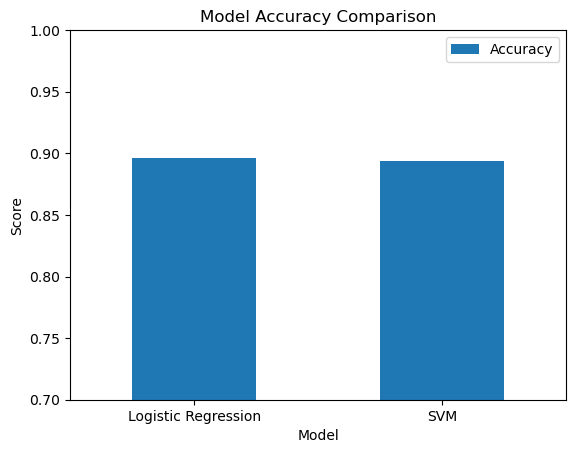

In [37]:
plt.figure(figsize=(10, 6))
metric_df[['Accuracy']].plot(kind='bar', rot=0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.show()

In [38]:
best_model_name = max(results, key=lambda x: x['Validation Accuracy'])['Model']
best_model = models[best_model_name]

print(f"\n{'='*40}\nEvaluating Best Model ({best_model_name}) on Test Set\n{'='*40}")

# Test evaluation
y_test_pred = best_model.predict(X_test_tfidf)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))


Evaluating Best Model (Logistic Regression) on Test Set
Test Accuracy: 0.8939
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      2470
    positive       0.88      0.91      0.90      2489

    accuracy                           0.89      4959
   macro avg       0.89      0.89      0.89      4959
weighted avg       0.89      0.89      0.89      4959



In [39]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [40]:
def predict_sentiment(text, model=best_model):
    """End-to-end sentiment prediction pipeline"""
    cleaned_text = preprocess_text(text)
    vectorized_text = tfidf.transform([cleaned_text])
    return model.predict(vectorized_text)[0]

In [41]:
test_reviews = [
    "Misleading advertising. Total letdown.",
    "Complicated to use and unreliable. Frustrating experience.",
    "Worst purchase ever. Constant issues from day one.",
    "Fast shipping and top-notch quality. Will buy again!",
    "User-friendly design and outstanding performance. A game-changer!",
    "Absolutely love this product! It exceeded all my expectations.",
    "It is not really good."
]

print("\nSample Predictions:")
for review in test_reviews:
    prediction = predict_sentiment(review)
    print(f"\nReview: {review}\nPredicted Sentiment: {prediction}")
    print("-"*60)


Sample Predictions:

Review: Misleading advertising. Total letdown.
Predicted Sentiment: negative
------------------------------------------------------------

Review: Complicated to use and unreliable. Frustrating experience.
Predicted Sentiment: positive
------------------------------------------------------------

Review: Worst purchase ever. Constant issues from day one.
Predicted Sentiment: negative
------------------------------------------------------------

Review: Fast shipping and top-notch quality. Will buy again!
Predicted Sentiment: positive
------------------------------------------------------------

Review: User-friendly design and outstanding performance. A game-changer!
Predicted Sentiment: positive
------------------------------------------------------------

Review: Absolutely love this product! It exceeded all my expectations.
Predicted Sentiment: positive
------------------------------------------------------------

Review: It is not really good.
Predicted Sentim